In [1]:
import sys
sys.path.insert(0, '../backend')
sys.path.insert(0, '../../data')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from collections import defaultdict
import torch
from similaritymeasures import frechet_dist, dtw

import signatory 
from linear_RDE_solver import *
from path_tools import *
from pvar_tools import *

In [3]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'], 'size':12})

# Example of reparametrisation

In [4]:
t = np.linspace(0,1,200)

In [5]:
x1 = t
x2 = t**5

y1 = np.cos(10*x1)
z1 = np.sin(3*x1)

y2 = np.cos(10*x2)
z2 = np.sin(3*x2)

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


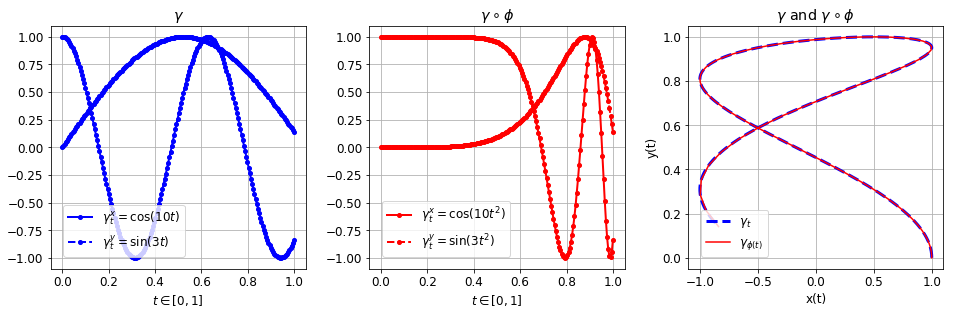

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(16,5))
fig.subplots_adjust(top=0.8, wspace=0.25)

ax[0].plot(x1, y1, label='$\gamma^x_t = \cos(10t)$', linestyle='-', marker='o', color='b', lw=2, markersize=4)
ax[0].plot(x1, z1, label='$\gamma^y_t = \sin(3t)$', linestyle='--', marker='o', color='b', lw=2, markersize=4)
ax[0].set_title('$\gamma$')
ax[0].grid(True)
ax[0].legend(loc=(.05,.05))
ax[0].set_xlabel('$t \in [0,1]$')

ax[1].plot(x1, y2, label='$\gamma^x_t = \cos(10t^2)$', linestyle='-', marker='o', color='r', lw=2, markersize=4)
ax[1].plot(x1, z2, label='$\gamma^y_t = \sin(3t^2)$', linestyle='--', marker='o', color='r', lw=2, markersize=4)
ax[1].legend(loc=(.05,.05))
ax[1].grid(True)
ax[1].set_title('$\gamma \circ \phi$')
ax[1].set_xlabel('$t \in [0,1]$')

ax[2].plot(y1, z1, label='$\gamma_t$',  linestyle='--', c='b', lw=3)
ax[2].plot(y2, z2, label='$\gamma_{\phi(t)}$', c='r', linestyle='-')
ax[2].grid(True)
ax[2].legend(loc=(.05,.05))
ax[2].set_xlabel('x(t)')
ax[2].set_ylabel('y(t)')
ax[2].set_title('$\gamma$ and $\gamma \circ \phi$')

# plt.suptitle('Planar curve $\gamma$ reparametrised by $\phi: t \mapsto t^2$')
plt.savefig('../images/planar_curve')
plt.show()

# Pure Area path

In [4]:
N = 100

In [5]:
depth = 2 

In [6]:
p = 2.1

In [7]:
time = torch.linspace(0., 1., N)

In [8]:
max_iteration = 1e2
nb_iterations = 100
iterations = np.linspace(2., max_iteration, nb_iterations).astype(int)

In [9]:
x_inf = x_limit(N) # limit in Lq of X_n
X_inf = X_limit(N, depth, time) # limit in p-var of (X_n, XX_n)

In [10]:
y_inf = response_limit(N, time) # final response of the controlled system

In [11]:
sequence_x = [] # sequence of paths {X_n}
sequence_X = [] # sequence of rough paths {(X_n, XX_n)}

sequence_y = [] # solution to the RDE driven by the path X_n
sequence_Y = [] # solution to the RDE deiven by rough path (X_n, XX_n)

for n in iterations:
    
    x = sine_wave_path(n, N, time) # path X_n
    sequence_x.append(x)
    
    X = sine_wave_rough_path(n, N, time) # rough path (X_n, XX_n)
    sequence_X.append(X)
    
    sequence_y.append(Ito_map(x)) # Ito map of X_n
    sequence_Y.append(Ito_map(X)) # Ito map of (X_n, XX_n)
    
#     sequence_y.append(torch.tensor(flow(x.squeeze(0).cpu().numpy(), B, R, Y0), dtype=torch.float).unsqueeze(0).cuda())
#     sequence_Y.append(torch.tensor(flow(X.squeeze(0).cpu().numpy(), B, R, Y0), dtype=torch.float).unsqueeze(0).cuda())

In [12]:
eg_x = torch.zeros(nb_iterations, sequence_x[0].shape[1], sequence_x[0].shape[2])#.cuda()
batch_x = signatory.Path(torch.cat(sequence_x, out=eg_x), 1, basepoint=True)
# batch_x = signatory.Path(torch.cat(sequence_x, out=eg_x).cuda(), 1, basepoint=True)

eg_X = torch.zeros(nb_iterations, sequence_X[0].shape[1], sequence_X[0].shape[2])#.cuda()
batch_X = signatory.Path(torch.cat(sequence_X, out=eg_X), 1, basepoint=True)
# batch_X = signatory.Path(torch.cat(sequence_X, out=eg_X).cuda(), 1, basepoint=True)

eg_y = torch.zeros(nb_iterations, sequence_y[0].shape[1], sequence_y[0].shape[2])#.cuda()
batch_y = signatory.Path(torch.cat(sequence_y, out=eg_y), 1, basepoint=True)
# batch_y = signatory.Path(torch.cat(sequence_y, out=eg_y).cuda(), 1, basepoint=True)

eg_Y = torch.zeros(nb_iterations, sequence_Y[0].shape[1], sequence_Y[0].shape[2])#.cuda()
batch_Y = signatory.Path(torch.cat(sequence_Y, out=eg_Y), 1, basepoint=True)
# batch_Y = signatory.Path(torch.cat(sequence_Y, out=eg_Y).cuda(), 1, basepoint=True)

In [13]:
metrics = [lambda x,y: Lq(x,y,2), 
           frechet_dist,
           lambda x,y: dtw(x,y)[0], 
           lambda X, Y: p_variation_distance(X, Y, p, norm='l1')
          ]

results = defaultdict(list)

listX = [signatory.Path(k.unsqueeze(0), 1, basepoint=True) for k in batch_X._signature[0]]
listY = [signatory.Path(k.unsqueeze(0), 1, basepoint=True) for k in batch_Y._signature[0]]

In [14]:
types = ['Euclidean', 
         'Frechet', 
         'DTW', 
         'p-var'
        ]

In [15]:
import time
t = time.time()
p_variation_distance(X_inf, listX[0], p)
print('{:.2f} sec'.format(time.time()-t))

2.83 sec


In [16]:
import time
t = time.time()
p_variation_distance_approx(X_inf, listX[0], p)
print('{:.2f} sec'.format(time.time()-t))

1.22 sec


In [17]:
for metric, m in zip(metrics, types):   
    if m == 'p-var':
        for X, Y in zip(listX, listY):
            results[m].append([metric(X, X_inf), metric(Y, y_inf)])
    else:
        for x, y in zip(batch_x._signature[0], batch_y._signature[0]):
            results[m].append([metric(x.cpu().numpy(), x_inf._signature[0][0,:,:].cpu().squeeze(0).numpy()), 
                               metric(y.cpu().numpy(), y_inf._signature[0][0,:,:].cpu().squeeze(0).numpy())])

In [18]:
from matplotlib.gridspec import GridSpec
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'], 'size':13})

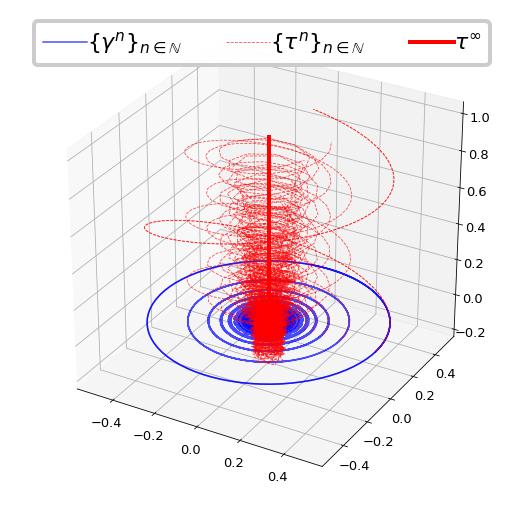

In [78]:
fig = plt.figure(figsize=(9, 10))
# gs = GridSpec(nrows=12, ncols=7)
fig.subplots_adjust(top=0.8)

ax = fig.add_subplot(1,1,1,projection='3d')

ax.plot(x_inf._signature[0][0,:,0].cpu().numpy(), x_inf._signature[0][0,:,1].cpu().numpy(), color='blue',
        label='$%s$'%'\{\gamma^n\}_{n \in \mathbb{N}}', linewidth=1.5, alpha=0.7)
for x in batch_x._signature[0]:
    ax.plot(x[:,0].cpu().numpy(), x[:,1].cpu().numpy(), linewidth=1.5, alpha=0.7, color='blue')

ax.plot3D(y_[:,0].cpu().numpy(), y_[:,1].cpu().numpy(), y_[:,2].cpu().numpy(), alpha=0.7, color='r', linestyle='--', lw=0.8, 
          label='$%s$'%'\{\u03C4^n\}_{n \in \mathbb{N}}')
for y in batch_y._signature[0][1:]:
    ax.plot3D(y[:,0].cpu().numpy(), y[:,1].cpu().numpy(), y[:,2].cpu().numpy(), alpha=0.7, c='r', linestyle='--', lw=0.8)
    
y_ = batch_y._signature[0][0]
ax.plot3D(y_inf._signature[0][0,:,0].cpu().numpy(), y_inf._signature[0][0,:,1].cpu().numpy(), 
          y_inf._signature[0][0,:,2].cpu().numpy(),  linewidth=4, color='red', linestyle='-', 
          label='$%s$'%'\u03C4^\infty')
    
leg = ax.legend(ncol=3, loc='upper center', framealpha=5, prop={'size': 22}, fancybox=True, facecolor='white', 
                handletextpad=0, labelspacing=0)
leg.get_frame().set_linewidth(4.0)
plt.savefig('../images/pure_area.png')
plt.show()

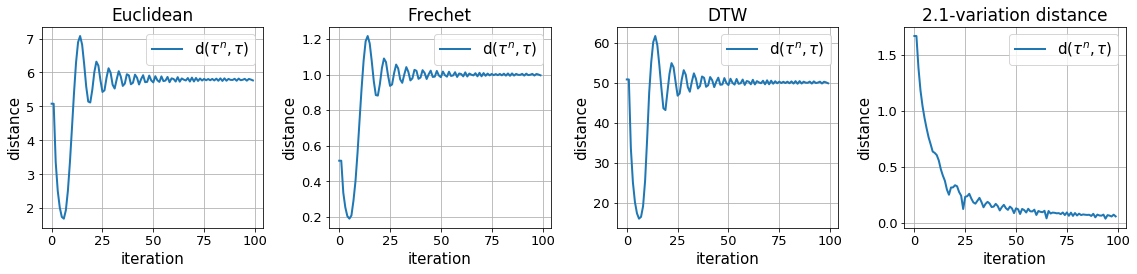

In [53]:
fig = plt.figure(figsize=(16, 4))
gs = GridSpec(nrows=1, ncols=4)
fig.subplots_adjust(top=0.8)

k = 0
for typ in types:
    ax = fig.add_subplot(gs[:, k])
    convergence = np.array(results[typ])
    ax.plot(convergence.T[1], label='d$%s$'%'(\u03C4^n, \u03C4)', lw=2)
    if typ=='p-var':
        typ='{:.1f}-variation distance'.format(p)
    ax.set_title(typ, fontsize=17)
    ax.set_xlabel('iteration', fontsize=15)
    ax.set_ylabel('distance', fontsize=15)
    ax.grid(True)
    ax.legend(fontsize=15)
    k += 1

plt.tight_layout()
plt.savefig('../images/convergence.png')
plt.show()